In [249]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [250]:

df = pd.read_csv('data/MAIN.csv')

# Handle missing values (if any)
df = df.dropna()

test_2020_copy = df[df['year'] == 2020].copy()[['year','state']]

# Drop the specified string variables
df = df.drop(columns=['state', 'republican_candidate', 'democratic_candidate', 'democratic_candidate_normalized', 'republican_candidate_normalized'])

# Create the final test set for the year 2020
test_2020 = df[df['year'] == 2020]
test_2020_X = test_2020.drop('proportion_democrat_president', axis=1).values
test_2020_y = test_2020['proportion_democrat_president'].values

# Remove 2020 data from the original dataset to use for training and validation
df = df[df['year'] != 2020]

# Convert categorical variables to dummy/indicator variables (one-hot encoding) if there are any left
df = pd.get_dummies(df)
test_2020 = pd.get_dummies(test_2020)

# Ensure both train and test sets have the same columns after one-hot encoding
df, test_2020 = df.align(test_2020, join='left', axis=1, fill_value=0)
# Split into features and target
X = df.drop('proportion_democrat_president', axis=1).values
y = df['proportion_democrat_president'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_2020_X = scaler.transform(test_2020_X)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
test_2020_X = torch.tensor(test_2020_X, dtype=torch.float32)
test_2020_y = torch.tensor(test_2020_y, dtype=torch.float32).view(-1, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
test_2020_dataset = TensorDataset(test_2020_X, test_2020_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_2020_loader = DataLoader(test_2020_dataset, batch_size=32, shuffle=False)

input_dim = X.shape
output_dim = y.shape
print(f'The input dimension is: {input_dim}')
print(f'The output dimension is: {input_dim}')


The input dimension is: torch.Size([500, 9])
The output dimension is: torch.Size([500, 9])


In [251]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        # self.fc2 = nn.Linear(X.shape[1]//2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        # x = torch.relu(self.fc2(x))
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [252]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.0361
Epoch [2/100], Loss: 0.0127
Epoch [3/100], Loss: 0.0117
Epoch [4/100], Loss: 0.0084
Epoch [5/100], Loss: 0.0109
Epoch [6/100], Loss: 0.0262
Epoch [7/100], Loss: 0.0096
Epoch [8/100], Loss: 0.0050
Epoch [9/100], Loss: 0.0074
Epoch [10/100], Loss: 0.0107
Epoch [11/100], Loss: 0.0069
Epoch [12/100], Loss: 0.0059
Epoch [13/100], Loss: 0.0031
Epoch [14/100], Loss: 0.0045
Epoch [15/100], Loss: 0.0065
Epoch [16/100], Loss: 0.0037
Epoch [17/100], Loss: 0.0041
Epoch [18/100], Loss: 0.0029
Epoch [19/100], Loss: 0.0094
Epoch [20/100], Loss: 0.0059
Epoch [21/100], Loss: 0.0021
Epoch [22/100], Loss: 0.0041
Epoch [23/100], Loss: 0.0065
Epoch [24/100], Loss: 0.0022
Epoch [25/100], Loss: 0.0022
Epoch [26/100], Loss: 0.0032
Epoch [27/100], Loss: 0.0025
Epoch [28/100], Loss: 0.0029
Epoch [29/100], Loss: 0.0034
Epoch [30/100], Loss: 0.0016
Epoch [31/100], Loss: 0.0021
Epoch [32/100], Loss: 0.0038
Epoch [33/100], Loss: 0.0018
Epoch [34/100], Loss: 0.0032
Epoch [35/100], Loss: 0

In [253]:
model.eval()
with torch.no_grad():
    test_losses = []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_losses.append(loss.item())

    print(f'Average Test Loss: {sum(test_losses)/len(test_losses):.4f}')

    # Evaluate on the 2020 test set
    test_2020_losses = []
    for batch_X, batch_y in test_2020_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_2020_losses.append(loss.item())

    print(f'Average Test Loss for 2020: {sum(test_2020_losses)/len(test_2020_losses):.4f}')


Average Test Loss: 0.0010
Average Test Loss for 2020: 0.0006


Findings: The simpler the model was, the lower the loss. Loss of one linear layer < Loss of one linear and one ReLU < Loss of linear, ReLU, and Dropout. It seems like logistic regression is the best way to predict general election results given this limited data

In [254]:
# Predict on the 2020 test set
model.eval()
with torch.no_grad():
    predictions = []
    for batch_X, _ in test_2020_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.numpy())

# Convert predictions to a DataFrame for easier viewing
predictions_df = pd.DataFrame(predictions, columns=['predicted_proportion'])
test_2020_copy.reset_index(drop=True, inplace=True)
result_df = pd.concat([test_2020_copy, predictions_df], axis=1)
electoral_votes = {
    "ALABAMA": 9,
    "ALASKA": 3,
    "ARIZONA": 11,
    "ARKANSAS": 6,
    "CALIFORNIA": 55,
    "COLORADO": 9,
    "CONNECTICUT": 7,
    "DELAWARE": 3,
    "DISTRICT OF COLUMBIA": 3,
    "FLORIDA": 29,
    "GEORGIA": 16,
    "HAWAII": 4,
    "IDAHO": 4,
    "ILLINOIS": 20,
    "INDIANA": 11,
    "IOWA": 6,
    "KANSAS": 6,
    "KENTUCKY": 8,
    "LOUISIANA": 8,
    "MAINE": 4,
    "MARYLAND": 10,
    "MASSACHUSETTS": 11,
    "MICHIGAN": 16,
    "MINNESOTA": 10,
    "MISSISSIPPI": 6,
    "MISSOURI": 10,
    "MONTANA": 3,
    "NEBRASKA": 5,
    "NEVADA": 6,
    "NEW HAMPSHIRE": 4,
    "NEW JERSEY": 14,
    "NEW MEXICO": 5,
    "NEW YORK": 29,
    "NORTH CAROLINA": 15,
    "NORTH DAKOTA": 3,
    "OHIO": 18,
    "OKLAHOMA": 7,
    "OREGON": 7,
    "PENNSYLVANIA": 20,
    "RHODE ISLAND": 4,
    "SOUTH CAROLINA": 9,
    "SOUTH DAKOTA": 3,
    "TENNESSEE": 11,
    "TEXAS": 38,
    "UTAH": 6,
    "VERMONT": 3,
    "VIRGINIA": 13,
    "WASHINGTON": 12,
    "WEST VIRGINIA": 5,
    "WISCONSIN": 10,
    "WYOMING": 3
}
result_df['electoral_votes'] = result_df['state'].apply(lambda x: electoral_votes[x.upper()])
print(result_df)

# Calculate the weighted sum of predicted_proportion * electoral_votes
result_df['democratic_votes'] = result_df.apply(lambda row: row['electoral_votes'] if row['predicted_proportion'] > 0.5 else 0, axis=1)
# Calculate the total electoral votes for Democrats
total_democratic_votes = result_df['democratic_votes'].sum()
print(f'Model expected outcome: Biden: {int(total_democratic_votes)}, Trump: {538-int(total_democratic_votes)}')
print('True outcome: Biden: 306, Trump: 232')

    year                 state  predicted_proportion  electoral_votes
0   2020               ALABAMA              0.389075                9
1   2020                ALASKA              0.438374                3
2   2020               ARIZONA              0.506825               11
3   2020              ARKANSAS              0.376399                6
4   2020            CALIFORNIA              0.641146               55
5   2020              COLORADO              0.551945                9
6   2020           CONNECTICUT              0.619281                7
7   2020              DELAWARE              0.617236                3
8   2020  DISTRICT OF COLUMBIA              0.904186                3
9   2020               FLORIDA              0.515294               29
10  2020               GEORGIA              0.508338               16
11  2020                HAWAII              0.674564                4
12  2020                 IDAHO              0.380212                4
13  2020            

While these proportions are helpful in measuring expected outcomes, they aren't alone too useful in predicting the probability of a cantidate winning the general election because state outcomes aren't IID. For example, if voters in Alabama vote republican more than the predicted outcome suggests, then voters in Mississippi are likely to do the same. To simulate this, I'm going to repeatedly sample from a normal random variable with standard deviation 0.02 (arbitrarily chosen, this could be high), to represent variability of nationwide decisions, and add it to the predicted probability of each state. I'm hoping that this will be a decent way to predict the probability a cantidate wins the election. 

Democrats win in 8894 out of 10000 simulations in 2020.
Republicans win in 1106 out of 10000 simulations in 2020.


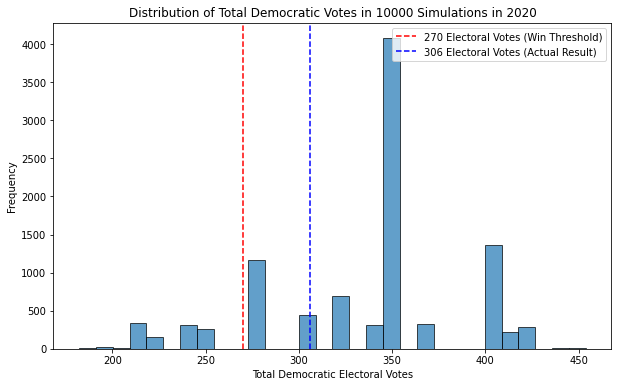

In [256]:
# Add electoral votes column to result_df
result_df['electoral_votes'] = result_df['state'].apply(lambda x: electoral_votes[x.upper()])

# Monte Carlo simulation
n_simulations = 10000
democrat_wins = 0
total_democratic_votes_list = []

for _ in range(n_simulations):
    # Sample a random variable with mean 0 and standard deviation 0.02
    noise = np.random.normal(0, 0.02)
    # Add the same noise to the predicted_proportion for each state
    result_df['adjusted_proportion'] = result_df['predicted_proportion'] + noise
    
    # Determine the winner of each state
    result_df['democratic_votes'] = result_df.apply(lambda row: row['electoral_votes'] if row['adjusted_proportion'] > 0.5 else 0, axis=1)
    
    # Calculate the total electoral votes for Democrats
    total_democratic_votes = result_df['democratic_votes'].sum()
    total_democratic_votes_list.append(total_democratic_votes)
    
    # Count the number of wins for Democrats
    if total_democratic_votes >= 270:
        democrat_wins += 1

# Print the number of wins
print(f'Democrats win in {democrat_wins} out of {n_simulations} simulations in 2020.')
print(f'Republicans win in {n_simulations - democrat_wins} out of {n_simulations} simulations in 2020.')
# Plot the total democratic votes in each simulation
plt.figure(figsize=(10, 6))
plt.hist(total_democratic_votes_list, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(x=270, color='r', linestyle='--', label='270 Electoral Votes (Win Threshold)')
plt.axvline(x=306, color='b', linestyle='--', label='306 Electoral Votes (Actual Result)')
plt.title('Distribution of Total Democratic Votes in 10000 Simulations in 2020')
plt.xlabel('Total Democratic Electoral Votes')
plt.ylabel('Frequency')
plt.legend()
plt.show()
